## Part 2: The Pipeline + GridSearch Way

In [1]:
# Import pandas and set the standard alias 
from fsds.imports import *

fsds v0.2.25 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
# Import the data from 'titanic.csv' and store it in a pandas DataFrame 
raw_df = fs.datasets.load_titanic(read_csv_kwds={'index_col':0})
raw_df.drop(columns= ['PassengerId', 'Name', 'Ticket', 'Cabin'],
            inplace=True)

# Print the head of the DataFrame to ensure everything loaded correctly 
df = raw_df.copy()
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,?,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


> ### Create training and test sets
* Use `train_test_split()` to split the data into training and test sets, with a `test_size` of `0.25`. Set the `random_state` to 42 

In [3]:
from sklearn.model_selection import train_test_split

## Get X, y and train-test-split
target = 'Survived'
X = df.drop(columns=target).copy()
y = df[target].copy()


## train tst split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,
                                                    random_state=42)
[print(var.shape) for var in [X_train, X_test]];

(668, 7)
(223, 7)


### Required Preprocessing

> Since you've done this before, you should be able to do this quite well yourself without much hand holding by now. In the cells below, complete the following steps:
1. ~~Remove unnecessary columns (`'PassengerId'`, `'Name'`, `'Ticket'`, and `'Cabin'`) ~~
2. Convert `'Sex'` to a binary encoding, where female is `0` and male is `1` 
3. Detect and deal with any missing values in the dataset:  
    * For `'Age'`, replace missing values with the median age for the dataset  
    * For `'Embarked'`, drop the rows that contain missing values
4. One-hot encode categorical columns such as `'Embarked'` 
5. Store the target column, `'Survived'`, in a separate variable and remove it from the DataFrame  

> #### Normalizing the data 
* Import and instantiate `StandardScaler` 
* Use the scaler's `.fit_transform()` method to create a scaled version of the training dataset  
* Use the scaler's `.transform()` method to create a scaled version of the test dataset  
* The result returned by `.fit_transform()` and `.transform()` methods will be numpy arrays, not a pandas DataFrame. Create a new pandas DataFrame out of this object called `scaled_df`. To set the column names back to their original state, set the `columns` parameter to `one_hot_df.columns` 
* Print the head of `scaled_df` to ensure everything worked correctly 

## Preprocessing with Pipelines +  `ColumnTransformer`

- [Pipeline Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- [ColumnTransformer Documentation](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [4]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### Preprocess Numeric Columns

In [5]:
## Get list of numeric features to sacle
target='Survived'
num_cols = df.drop(columns=target).select_dtypes('number').columns.tolist()
num_cols

['Age', 'SibSp', 'Parch', 'Fare']

In [6]:
## Create a num_trasnformer pipeline 
## that will impute using median and then calculate z-scores
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale',StandardScaler())])

In [7]:
## .fit_transform X_train
X_train_tf = num_transformer.fit_transform(X_train[num_cols])
X_train_tf

array([[-0.08764782, -0.46765956, -0.46887833, -0.0325683 ],
       [-0.31820308, -0.46765956, -0.46887833, -0.48733085],
       [-0.39505484, -0.46765956,  2.04687047, -0.34285405],
       ...,
       [ 0.91142501,  1.22097065, -0.46887833, -0.35045024],
       [-1.1635724 ,  0.37665554,  2.04687047,  1.7030926 ],
       [-0.62561011, -0.46765956,  0.78899607,  0.8747751 ]])

In [8]:
## Get X_train_tf_num, and X_test_tf_num


#### Categorical Features


In [9]:
## Get list of cat features to encode
cat_cols = df.drop(columns=target).select_dtypes('O').columns.tolist()
cat_cols

['Pclass', 'Sex', 'Embarked']

In [10]:
## Create a cat_transformer pipeline 
## that will impute using median and then calculate z-scores
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [11]:
## Fit-transform data
X_train_cat =cat_transformer.fit_transform(X_train[cat_cols])
X_train_cat 

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

## Putting it all together with ColumnTransformer

- Column Transformer DOocumentation: 
- https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

In [13]:
## Display Pipelines from earlier
num_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [14]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessing=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

### Viewing Pipeline

In [15]:
from sklearn import set_config
set_config(display='diagram')

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [16]:
## Get X_train and X_test from column transformer
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [17]:
X_train_tf

array([[-0.08764782, -0.46765956, -0.46887833, ...,  0.        ,
         1.        ,  0.        ],
       [-0.31820308, -0.46765956, -0.46887833, ...,  0.        ,
         1.        ,  0.        ],
       [-0.39505484, -0.46765956,  2.04687047, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.91142501,  1.22097065, -0.46887833, ...,  0.        ,
         1.        ,  0.        ],
       [-1.1635724 ,  0.37665554,  2.04687047, ...,  0.        ,
         1.        ,  0.        ],
       [-0.62561011, -0.46765956,  0.78899607, ...,  0.        ,
         1.        ,  0.        ]])

### Finding Feature Names

In [18]:
set_config(display='diagram')

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [19]:
## Explore the named_transformers
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Pclass_?',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_missing']

In [20]:
feature_names

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Pclass_?',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_missing']

In [21]:
## Find the encoder inside the cat transformer
X_cols = num_cols+feature_names
X_cols

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Pclass_?',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_missing']

In [22]:
## Use the encoder.get_feature_names()
X_train_df = pd.DataFrame(X_train_tf,columns=X_cols)
X_test_df = pd.DataFrame(X_test_tf,columns=X_cols)
X_train_df

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Pclass_?,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,-0.087648,-0.467660,-0.468878,-0.032568,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.318203,-0.467660,-0.468878,-0.487331,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.395055,-0.467660,2.046870,-0.342854,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.548758,-0.467660,-0.468878,-0.478201,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-2.168793,0.376656,2.046870,2.314937,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,-0.625610,-0.467660,-0.468878,-0.475695,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
664,-0.087648,-0.467660,-0.468878,-0.022872,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
665,0.911425,1.220971,-0.468878,-0.350450,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
666,-1.163572,0.376656,2.046870,1.703093,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


> ## Fit a KNN model
Now that you've preprocessed the data it's time to train a KNN classifier and validate its accuracy. 
In the cells below:
* Import `KNeighborsClassifier` from the `sklearn.neighbors` module 
* Instantiate the classifier. For now, you can just use the default parameters  
* Fit the classifier to the training data/labels
* Use the classifier to generate predictions on the test data. Store these predictions inside the variable `test_preds` 

In [23]:
from sklearn.neighbors import KNeighborsClassifier
## Use our preprocessor as the first step in a modeling pipelien
knn_pipe = Pipeline(steps=[('preprocessing',preprocessing),
                          ('knn',KNeighborsClassifier())])
knn_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('knn', KNeighborsClassifier())])

In [24]:
## Fit pipeline
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('knn', KNeighborsClassifier())])

In [25]:
from sklearn import metrics

In [26]:
## Get predictions, score
y_hat_test = knn_pipe.predict(X_test)
print(metrics.classification_report(y_test,y_hat_test))
# pipeline.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       134
           1       0.77      0.71      0.74        89

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



> ## Evaluate the model
- Here we will deviate and we will use the assignment/challenge function `evaluate_classification` from sect 25-Pt2 s.g.

### ✅ Activity: Make an `evaluate_classification` function

- From last class

In [27]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Purples',label=''):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report #fig,axes

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       134
           1       0.77      0.71      0.74        89

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223

------------------------------------------------------------




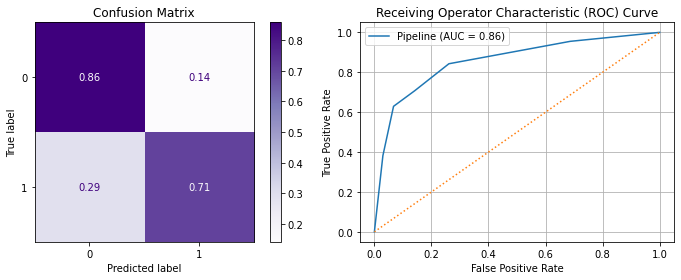

{'0': {'precision': 0.8156028368794326,
  'recall': 0.8582089552238806,
  'f1-score': 0.8363636363636363,
  'support': 134},
 '1': {'precision': 0.7682926829268293,
  'recall': 0.7078651685393258,
  'f1-score': 0.736842105263158,
  'support': 89},
 'accuracy': 0.7982062780269058,
 'macro avg': {'precision': 0.7919477599031309,
  'recall': 0.7830370618816032,
  'f1-score': 0.7866028708133972,
  'support': 223},
 'weighted avg': {'precision': 0.7967212059297389,
  'recall': 0.7982062780269058,
  'f1-score': 0.7966442809020103,
  'support': 223}}

In [28]:
## Evaluate model with our function
evaluate_classification(knn_pipe,X_test,y_test)

> Interpret each of the metrics above, and explain what they tell you about your model's capabilities. If you had to pick one score to best describe the performance of the model, which would you choose? Explain your answer.
- Discuss as a group


>## Improve model performance
While your overall model results should be better than random chance, they're probably mediocre at best given that you haven't tuned the model yet. For the remainder of this notebook, you'll focus on improving your model's performance. Remember that modeling is an **_iterative process_**, and developing a baseline out of the box model such as the one above is always a good start. <br>
First, try to find the optimal number of neighbors to use for the classifier. To do this, complete the `find_best_k()` function below to iterate over multiple values of K and find the value of K that returns the best overall performance. <br><br>
**The function takes in six arguments:**
* `X_train`
* `y_train`
* `X_test`
* `y_test`
* `min_k` (default is 1)
* `max_k` (default is 25)
    
> **Pseudocode Hint**:
1. Create two variables, `best_k` and `best_score`
1. Iterate through every **_odd number_** between `min_k` and `max_k + 1`. 
    1. For each iteration:
        1. Create a new `KNN` classifier, and set the `n_neighbors` parameter to the current value for k, as determined by the loop 
        1. Fit this classifier to the training data 
        1. Generate predictions for `X_test` using the fitted classifier 
        1. Calculate the **_F1-score_** for these predictions 
        1. Compare this F1-score to `best_score`. If better, update `best_score` and `best_k` 
1. Once all iterations are complete, print the best value for k and the F1-score it achieved 

### Finding the Best K

In [29]:
import warnings
warnings.filterwarnings('ignore')
set_config(display='diagram')

#### Can we GridSearch with a Pipeline?



> #### YES! Param Grids for Pipelines:
- Add the name of the step plus a dunder `__` as a prefix to the param name.

In [30]:
set_config(display='text')
knn_pipe.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scale', StandardScaler())]),
                                  ['Age', 'SibSp', 'Parch', 'Fare']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['Pclass', 'Sex', 'Embarked'])]),
 'knn': KNeighborsClassifier()}

In [31]:
from sklearn.model_selection import GridSearchCV

## Create Params grid for n_neighbors
params = {'knn__n_neighbors':list(range(1,26,2))}
params
## Create a GridSearch using F1 as scoring
grid = GridSearchCV(knn_pipe,params,scoring='f1')

In [32]:
## Fit and print best params
grid.fit(X_train, y_train)
grid.best_params_

{'knn__n_neighbors': 19}

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       134
           1       0.78      0.69      0.73        89

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223

------------------------------------------------------------




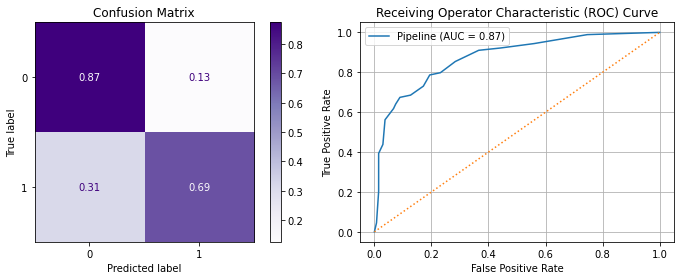

{'0': {'precision': 0.8068965517241379,
  'recall': 0.8731343283582089,
  'f1-score': 0.8387096774193548,
  'support': 134},
 '1': {'precision': 0.782051282051282,
  'recall': 0.6853932584269663,
  'f1-score': 0.7305389221556887,
  'support': 89},
 'accuracy': 0.7982062780269058,
 'macro avg': {'precision': 0.79447391688771,
  'recall': 0.7792637933925877,
  'f1-score': 0.7846242997875217,
  'support': 223},
 'weighted avg': {'precision': 0.7969807266080655,
  'recall': 0.7982062780269058,
  'f1-score': 0.7955383894441695,
  'support': 223}}

In [33]:
## Evaluate Model
evaluate_classification(grid.best_estimator_,X_test,y_test)

<AxesSubplot:xlabel='param_knn__n_neighbors'>

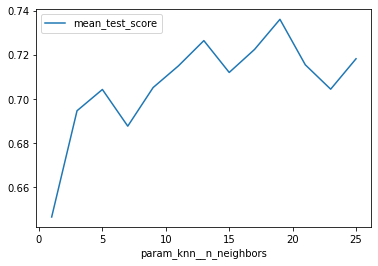

In [34]:
pd.DataFrame(grid.cv_results_).plot('param_knn__n_neighbors','mean_test_score')

### But how do we see the elbow plot for ks?

In [35]:
knn_pipe


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
        

> ## ~~(Optional) Level Up:~~ Iterating on the data
As an ~~optional (but recommended!)~~ exercise:
- think about the decisions you made during the preprocessing steps that could have affected the overall model performance. 
    - For instance, you were asked to **replace the missing age values with the column median.** Could this have affected the overall performance? 
    - How might the model have fared if you had just dropped those rows, instead of using the column median? 
    - What if you reduced the data's dimensionality by ignoring some less important columns altogether?
- In the cells below, revisit your preprocessing stage and see if you can improve the overall results of the classifier by doing things differently. 
    - Consider dropping certain columns, dealing with missing values differently, or using an alternative scaling function. 
    - Then see how these different preprocessing techniques affect the performance of the model. 
    - Remember that the `find_best_k()` function handles all of the fitting; use this to iterate quickly as you try different strategies for dealing with data preprocessing! 

> #### KNN PARAMS:
- n_neighbors - 1-25(odd)
- weights : uniform/distance
- metric: euclidean,minkowski,manhattan

> #### Prerocessing Params:
    - strategty='median','mean

In [36]:
params =  {'preprocessing__num__imputer__strategy':['mean','median'],
          'knn__n_neighbors':list(range(1,26,2)),
          'knn__metric':['euclidian','minkowski','manhattan']}
grid = GridSearchCV(knn_pipe,params,scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                

In [37]:
grid.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                         

In [38]:
grid.best_params_

{'knn__metric': 'manhattan',
 'knn__n_neighbors': 13,
 'preprocessing__num__imputer__strategy': 'mean'}

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       134
           1       0.81      0.71      0.75        89

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.82      0.82      0.81       223

------------------------------------------------------------




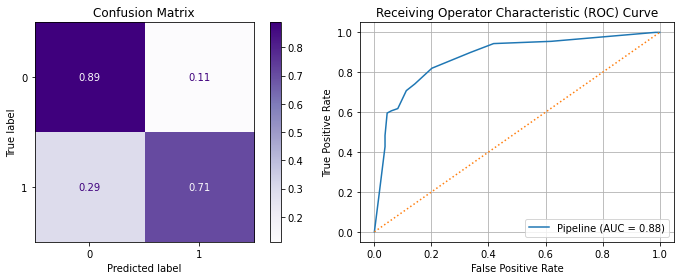

{'0': {'precision': 0.8206896551724138,
  'recall': 0.8880597014925373,
  'f1-score': 0.8530465949820788,
  'support': 134},
 '1': {'precision': 0.8076923076923077,
  'recall': 0.7078651685393258,
  'f1-score': 0.7544910179640719,
  'support': 89},
 'accuracy': 0.8161434977578476,
 'macro avg': {'precision': 0.8141909814323607,
  'recall': 0.7979624350159316,
  'f1-score': 0.8037688064730754,
  'support': 223},
 'weighted avg': {'precision': 0.8155023729942549,
  'recall': 0.8161434977578476,
  'f1-score': 0.8137127548269102,
  'support': 223}}

In [39]:
evaluate_classification(grid.best_estimator_, X_test,y_test)

> ## Fit a KNN model
Now that you've preprocessed the data it's time to train a KNN classifier and validate its accuracy. 
In the cells below:
* Import `KNeighborsClassifier` from the `sklearn.neighbors` module 
* Instantiate the classifier. For now, you can just use the default parameters  
* Fit the classifier to the training data/labels
* Use the classifier to generate predictions on the test data. Store these predictions inside the variable `test_preds` 

# Activity: Iowa Prisoners

In [40]:
!pip install -U fsds
from fsds.imports import *

Requirement already up-to-date: fsds in /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages (0.2.25)


In [41]:
# # prisoners = "https://raw.githubusercontent.com/jirvingphd/dsc-3-final-project-online-ds-ft-021119/master/iowa_recidivism_renamed.csv"
df = fs.datasets.load_iowa_prisoners(vers='clean',read_csv_kwds={'index_col':0})
## Drop unwanted cols
df= df.drop(columns=['yr_released','report_year'])
df.head()

,race_ethnicity,age_released,crime_class,crime_type,crime_subtype,release_type,super_dist,recidivist,target_pop,sex
0,Black - Non-Hispanic,25-34,C Felony,Violent,Robbery,Parole,7JD,Yes,Yes,Male
1,White - Non-Hispanic,25-34,D Felony,Property,Theft,Discharged – End of Sentence,NaN,Yes,No,Male
2,White - Non-Hispanic,35-44,B Felony,Drug,Trafficking,Parole,5JD,Yes,Yes,Male
3,White - Non-Hispanic,25-34,B Felony,Other,Other Criminal,Parole,6JD,No,Yes,Male
4,Black - Non-Hispanic,35-44,D Felony,Violent,Assault,Discharged – End of Sentence,NaN,Yes,No,Male


In [42]:
df.nunique().sum()

90

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020 entries, 0 to 26019
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   race_ethnicity  25990 non-null  object
 1   age_released    26017 non-null  object
 2   crime_class     26020 non-null  object
 3   crime_type      26020 non-null  object
 4   crime_subtype   26020 non-null  object
 5   release_type    24258 non-null  object
 6   super_dist      16439 non-null  object
 7   recidivist      26020 non-null  object
 8   target_pop      26020 non-null  object
 9   sex             26017 non-null  object
dtypes: object(10)
memory usage: 2.2+ MB


### Preprocessing Data

- Null values (fill or drop)
- Data Types (finding categorical variables)
- Inspect the value_counts/labels of categoricals
- Scaling or lack-off
- Encode Them
    - Label Encoding
    - One hot encoding


race_ethnicity      30
age_released         3
crime_class          0
crime_type           0
crime_subtype        0
release_type      1762
super_dist        9581
recidivist           0
target_pop           0
sex                  3
dtype: int64

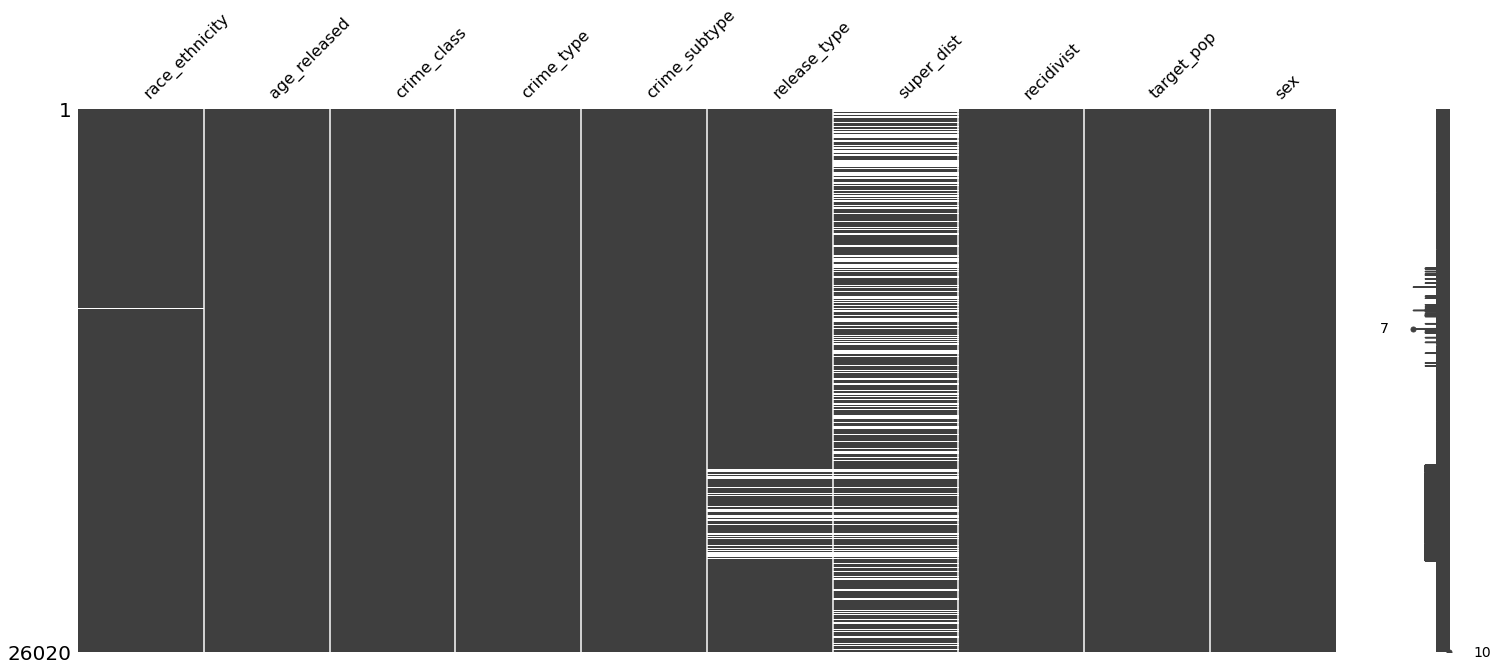

In [44]:
## Check null values
import missingno
missingno.matrix(df)
df.isna().sum()

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020 entries, 0 to 26019
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   race_ethnicity  25990 non-null  object
 1   age_released    26017 non-null  object
 2   crime_class     26020 non-null  object
 3   crime_type      26020 non-null  object
 4   crime_subtype   26020 non-null  object
 5   release_type    24258 non-null  object
 6   super_dist      16439 non-null  object
 7   recidivist      26020 non-null  object
 8   target_pop      26020 non-null  object
 9   sex             26017 non-null  object
dtypes: object(10)
memory usage: 2.2+ MB


### Simplifying Categorical Columns

In [46]:
df['race_ethnicity'].value_counts(dropna=False)

White - Non-Hispanic                               17584
Black - Non-Hispanic                                6109
White - Hispanic                                    1522
American Indian or Alaska Native - Non-Hispanic      502
Asian or Pacific Islander - Non-Hispanic             192
Black - Hispanic                                      37
NaN                                                   30
American Indian or Alaska Native - Hispanic           20
White -                                               12
Asian or Pacific Islander - Hispanic                   5
N/A -                                                  5
Black -                                                2
Name: race_ethnicity, dtype: int64

In [47]:
# Defining Dictionary Map for race_ethnicity categories
race_ethnicity_map = {
    'White - Non-Hispanic':'White',
    'Black - Non-Hispanic': 'Black',
    'White - Hispanic' : 'Hispanic',
    'American Indian or Alaska Native - Non-Hispanic' : 'American Native',
    'Asian or Pacific Islander - Non-Hispanic' : 'Asian or Pacific Islander',
    'Black - Hispanic' : 'Black',
    'American Indian or Alaska Native - Hispanic':'American Native',
    'White -' : 'White',
    'Asian or Pacific Islander - Hispanic' : 'Asian or Pacific Islander',
    'N/A -' : np.nan,
    'Black -':'Black'
}

df['race_ethnicity'] = df['race_ethnicity'].map(race_ethnicity_map)
df['race_ethnicity'].value_counts(dropna=False)

White                        17596
Black                         6148
Hispanic                      1522
American Native                522
Asian or Pacific Islander      197
NaN                             35
Name: race_ethnicity, dtype: int64

In [48]:
df['crime_class'].value_counts()

D Felony                                    10487
C Felony                                     6803
Aggravated Misdemeanor                       4930
B Felony                                     1765
Felony - Enhancement to Original Penalty     1533
Felony - Enhanced                             220
Serious Misdemeanor                           155
Special Sentence 2005                          98
Felony - Mandatory Minimum                     11
Other Felony                                    6
A Felony                                        4
Simple Misdemeanor                              3
Sexual Predator Community Supervision           2
Other Felony (Old Code)                         2
Other Misdemeanor                               1
Name: crime_class, dtype: int64

In [49]:
# Remapping
crime_class_map = {'Other Felony (Old Code)': np.nan ,#or other felony
                  'Other Misdemeanor':np.nan,
                   'Felony - Mandatory Minimum':np.nan, # if minimum then lowest sentence ==  D Felony
                   'Special Sentence 2005': 'Sex Offender',
                   'Other Felony' : np.nan ,
                   'Sexual Predator Community Supervision' : 'Sex Offender',
                   'D Felony': 'D Felony',
                   'C Felony' :'C Felony',
                   'B Felony' : 'B Felony',
                   'A Felony' : 'A Felony',
                   'Aggravated Misdemeanor':'Aggravated Misdemeanor',
                   'Felony - Enhancement to Original Penalty':'Felony - Enhanced',
                   'Felony - Enhanced':'Felony - Enhanced' ,
                   'Serious Misdemeanor':'Serious Misdemeanor',
                   'Simple Misdemeanor':'Simple Misdemeanor'}

df['crime_class'] = df['crime_class'].map(crime_class_map)
df['crime_class'].value_counts(dropna=False)

D Felony                  10487
C Felony                   6803
Aggravated Misdemeanor     4930
B Felony                   1765
Felony - Enhanced          1753
Serious Misdemeanor         155
Sex Offender                100
NaN                          20
A Felony                      4
Simple Misdemeanor            3
Name: crime_class, dtype: int64

In [50]:
df['age_released'].value_counts(dropna=False)

25-34           9554
35-44           6223
Under 25        4590
45-54           4347
55 and Older    1303
NaN                3
Name: age_released, dtype: int64

In [51]:
# Encoding age groups as ordinal
age_ranges = ('Under 25','25-34', '35-44','45-54','55 and Older')
age_codes = (0,1,2,3,4) 
# Zipping into Dictionary to Map onto Column
age_map = dict(zip(age_ranges,age_codes))
age_map

{'Under 25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55 and Older': 4}

In [52]:
df['age_enc'] = df['age_released'].map(age_map)
df['age_enc'].value_counts()

1.0    9554
2.0    6223
0.0    4590
3.0    4347
4.0    1303
Name: age_enc, dtype: int64

In [53]:
# Mapping age_map onto 'age_released'
# Encoding age groups as ordinal
age_ranges = ('Under 25','25-34', '35-44','45-54','55 and Older')
age_numbers = (20,30,40,50,70) 
age_num_map = dict(zip(age_ranges,age_numbers))
age_num_map

{'Under 25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55 and Older': 70}

In [54]:
df['age_number'] = df['age_released'].map(age_num_map)
df['age_number'].value_counts()

30.0    9554
40.0    6223
20.0    4590
50.0    4347
70.0    1303
Name: age_number, dtype: int64

In [55]:
df.drop(columns='age_released',inplace=True)

In [56]:
df.dtypes

race_ethnicity     object
crime_class        object
crime_type         object
crime_subtype      object
release_type       object
super_dist         object
recidivist         object
target_pop         object
sex                object
age_enc           float64
age_number        float64
dtype: object

### Train-Test-Split

In [57]:
y = df['recidivist']
X = df.drop(columns='recidivist')

In [58]:
y.value_counts(normalize=True)

No     0.666372
Yes    0.333628
Name: recidivist, dtype: float64

In [59]:
from sklearn.model_selection import train_test_split

## Train test split
X_train, X_test, y_train,y_test  = train_test_split(X,y,test_size=.3,stratify=y)

In [60]:
X_train

,race_ethnicity,crime_class,crime_type,crime_subtype,release_type,super_dist,target_pop,sex,age_enc,age_number
12151,White,D Felony,Violent,Assault,Discharged – End of Sentence,NaN,No,Male,1.0,30.0
12590,White,C Felony,Property,Burglary,Parole Granted,5JD,Yes,Male,2.0,40.0
23718,White,Aggravated Misdemeanor,Public Order,Other Public Order,Released to Special Sentence,2JD,No,Male,2.0,40.0
22937,White,D Felony,Property,Burglary,Parole Granted,2JD,Yes,Male,1.0,30.0
9389,White,D Felony,Property,Burglary,Discharged – End of Sentence,NaN,No,Male,1.0,30.0
...,...,...,...,...,...,...,...,...,...,...
22427,Black,Aggravated Misdemeanor,Property,Vandalism,Discharged - Expiration of Sentence,NaN,Yes,Male,2.0,40.0
6550,White,C Felony,Drug,Trafficking,Discharged – End of Sentence,NaN,No,Male,1.0,30.0
9448,White,D Felony,Property,Burglary,Discharged – End of Sentence,NaN,No,Male,3.0,50.0
20929,Black,Aggravated Misdemeanor,Public Order,OWI,Parole,1JD,Yes,Male,2.0,40.0


#### Pipelnes and ColumnTransformer

In [61]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [62]:
from sklearn import set_config
set_config(display='diagram')

In [63]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('O').columns
num_cols,cat_cols

(Index(['age_enc', 'age_number'], dtype='object'),
 Index(['race_ethnicity', 'crime_class', 'crime_type', 'crime_subtype',
        'release_type', 'super_dist', 'target_pop', 'sex'],
       dtype='object'))

In [64]:
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale',StandardScaler())])
num_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [65]:
## Create a cat_transformer pipeline 
## that will impute using median and then calculate z-scores
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])
cat_transformer

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [66]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessing=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 Index(['age_enc', 'age_number'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['race_ethnicity', 'crime_class', 'crime_type', 'crime_subtype',
       'release_type', 'super_dist', 'target_pop', 'sex'],
      dtype='object'))])

In [67]:
## Get X_train and X_test from column transformer
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)
X_train_tf

array([[-0.48467636, -0.47597117,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.42000649,  0.33935272,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.42000649,  0.33935272,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.32468934,  1.1546766 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.42000649,  0.33935272,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.48467636, -0.47597117,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [68]:
enc = preprocessing.named_transformers_['cat'].named_steps['encoder']
cat_features = enc.get_feature_names(cat_cols)

In [69]:
# ## Get Feature Names
# feature_names = preprocessing.named_transformers_['cat']\
#                 .named_steps['encoder'].get_feature_names(cat_cols)
# feature_names[:5]

In [70]:
X_train_ohe = pd.DataFrame(X_train_tf, columns=[*num_cols,*cat_features])
X_train_ohe

,age_enc,age_number,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,race_ethnicity_missing,crime_class_A Felony,crime_class_Aggravated Misdemeanor,...,super_dist_7JD,super_dist_8JD,super_dist_ISC,super_dist_Interstate Compact,super_dist_missing,target_pop_No,target_pop_Yes,sex_Female,sex_Male,sex_missing
0,-0.484676,-0.475971,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.420006,0.339353,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.420006,0.339353,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.484676,-0.475971,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.484676,-0.475971,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18209,0.420006,0.339353,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
18210,-0.484676,-0.475971,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
18211,1.324689,1.154677,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
18212,0.420006,0.339353,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [71]:
X_test_ohe = pd.DataFrame(X_test_tf, columns=[*num_cols,*cat_features])
X_test_ohe

,age_enc,age_number,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,race_ethnicity_missing,crime_class_A Felony,crime_class_Aggravated Misdemeanor,...,super_dist_7JD,super_dist_8JD,super_dist_ISC,super_dist_Interstate Compact,super_dist_missing,target_pop_No,target_pop_Yes,sex_Female,sex_Male,sex_missing
0,-0.484676,-0.475971,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.484676,-0.475971,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.324689,1.154677,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,-1.389359,-1.291295,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.484676,-0.475971,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7801,1.324689,1.154677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7802,1.324689,1.154677,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7803,-0.484676,-0.475971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7804,1.324689,1.154677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
